# Cats and Dogs Redux

We implement genetic algorithm to optimize a classification model that labels images of dogs and cats.
The model is a "light-weight" version of the  VGG16 architecture: 

1) Fewer blocks

2) Replaced regular convolution layer by **Dilated convolution** layer [https://arxiv.org/abs/1511.07122]

3) Use of **swish** activation function on the Fully connected layer [ https://arxiv.org/abs/1710.05941]

In [1]:
# Required libraries
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.utils import plot_model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from operator import itemgetter
import numpy as np
import cv2
import glob
import matplotlib.pylab as plt
import hashlib
import random
from PIL import Image
import seaborn
import pickle
#set random seed
np.random.seed(72)


Using TensorFlow backend.


In [2]:
from utils import build_dataset

def swish(x):
    '''
    Keras implementation of swish https://arxiv.org/abs/1710.05941
    '''
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

train_data, validation_data = build_dataset(5000, 0.25)


Set size Training: 3750 | Validation: 1250


In [3]:
class Configs():
    
    def __init__(self):
        self.total_nparams = 500000
        self.population_sz = 20
        self.image_specs = [32, 3]
    
    def list_activations(self):
        return {"relu": "relu", "elu": "elu", "swish":swish, "leaky_relu": LeakyReLU()}

    
    
class ClassifierDesign():
    
    def __init__(self, max_nparams, units_flatten, list_activations, max_cls_depth=10, lo_dropout=0.4, hi_dropout=1.0):
        self.max_nparams = max_nparams
        self.units_flatten = units_flatten
        self.list_activations = list_activations
        self.max_cls_depth = max_cls_depth
        self.hi_dropout = hi_dropout
        self.lo_dropout = lo_dropout
        self.design = list()
        self.build()
    
    
    def pick_num_units(self, current_nparams, units_prev_layer):
        '''
        Randomly pick number of units in a range so that the # of parameters of the model is below max_n_params
        
        before adding a layer (nl1: number of units of layer1)
        [nl1] - [nl2] - [nl3] - [output]
        n_params_before = nl1 * nl2 + nl2 * nl3 + nl3*output

        add nl4: [nl1] - [[nl2] - [nl3] > [nl4] < [output]
        n_params_after = nl1 * nl2 + nl2 * nl3 + nl3*nl4 + nl4*output
                       = n_params_init -nl3*output + nl3 * nl4 +nl4*output
        We want n_params_after <= max_nparams
        n_params_init -nl3*output + nl3 * nl4 +nl4*output <= max_n_params
        nl4 <= (max_n_params - n_params_init+nl3*output)/(nl3+output)
        '''
        low_units = 2#minimum number of units
        high_units = int( (self.max_nparams - current_nparams + units_prev_layer)*1./(units_prev_layer + 1) )
        if high_units <= low_units:
            return  low_units
        else:
            return np.random.randint(low=low_units, high=high_units)
        

        
    def build(self):
        '''
        build a classifier design with attributes randomly selected
        return a dict()
        '''
        cls_depth = np.random.choice( np.arange(0, self.max_cls_depth) )
        print("cls depth ", cls_depth)
        current_nparams = self.units_flatten
        units_prev_layer = self.units_flatten
        for layer_id in range(cls_depth - 1): #-1 for the output generated outside the loop
            if (self.max_nparams - current_nparams) < 1:
                #reaching the max number of parameters
                break
            else:
                layer_activ = np.random.choice( list( self.list_activations.keys() ) )
                layer_dropout = np.random.choice( np.arange(self.lo_dropout, self.hi_dropout, 0.1) )
                #pick num_units between 
                layer_units = self.pick_num_units(current_nparams, units_prev_layer)
                #Number of parameters when adding this layer
                current_nparams = current_nparams + units_prev_layer*(layer_units-1) + layer_units
                self.units_prev_layer = layer_units
                #attach new layer
                self.design.append({"units": layer_units, 
                                    "activation": layer_activ,
                                    "dropout": layer_dropout})
            
        #attach output layer
        self.design.append({"units": 1, "activation": "sigmoid", "dropout": None})
        
        

class ConvNet():
    
    def __init__(self, img_sz, img_ch):
        self.img_sz = img_sz
        self.img_ch = img_ch
        self.configs = Configs() 
        
        
    def initialize(self):
        self.model = Sequential()

        
    def add_feature_extractor(self):
        #image size = (32, 32, 3)
        self.model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(self.img_sz, self.img_sz, self.img_ch)))
        self.model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        #image size = (16, 16, 32)
        self.model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
        self.model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        #image size = (16, 16, 64)
        self.model.add(Conv2D(128, (3, 3), padding="same", dilation_rate=(2, 2), activation='relu'))
        self.model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        #image size = (7, 7, 128)
        self.model.add(Flatten(name="flatten") )        

        
    def add_classifier(self, cls_design):
        for layer in cls_design[:-1]:
            layer_activ = layer["activation"]
            layer_dropout = layer["dropout"]
            layer_units = layer["units"]
            
            self.model.add( Dense(layer_units, activation=self.configs.list_activations()[layer_activ]) )
            if layer_dropout:
                self.model.add( Dropout(layer_dropout) )

        #Add output layer
        self.model.add(Dense(1, activation='sigmoid'))



        
class GeneticAlgo():
    
    def __init__(self):
        self.history = {"scores": list(), "cls_designs": list(), "accuracy": list()}
        self.configs = Configs() 
        

    def design2model(self, specimen):
        cvnet = ConvNet(self.configs.image_specs[0], self.configs.image_specs[1])
        cvnet.initialize()
        #attach feature extractor : convolutional neural net
        cvnet.add_feature_extractor()
        #Attach NeuralNet to Classifier
        cvnet.add_classifier(specimen["cls_design"])
        specimen["model"] =  cvnet.model
        specimen["score"] = None
        return specimen
    
        
    def build_random_population(self):
        population = list()
        while (len(population) < self.configs.population_sz):
            cvnet = ConvNet(self.configs.image_specs[0], self.configs.image_specs[1])
            #Initialize sequential model
            cvnet.initialize()
            #attach feature extractor : convolutional neural net
            cvnet.add_feature_extractor()
            n_params_feat_extractor = cvnet.model.count_params()
            cls_max_nparams = self.configs.total_nparams - n_params_feat_extractor
            units_flatten = cvnet.model.get_layer(name="flatten").output_shape[1]
            #Generate random design for classifier
            cls = ClassifierDesign(cls_max_nparams, units_flatten, self.configs.list_activations())
            #Attach NeuralNet to Classifier
            cvnet.add_classifier(cls.design)
            specimen = {"model": cvnet.model, "cls_design": cls.design, "score": None}
            if specimen["cls_design"] not in (list( map(lambda x: x["cls_design"], population) ) ):
                #avoid clone design
                population.append(specimen)
        return population
    
    
    def sorted_specimen(self, population):
        '''
        sort specimen by score value (validation loss) from smaller to largest
        '''
        return sorted(population, key=itemgetter('score'), reverse=False)
    
    ####################
    #Genetic operators = selection, mutation, breeding
    ####################
    def keep_top_specimen(self, n_top, sorted_population):
        print("Top specimen score: {}".format(list(map(lambda x: x["score"], sorted_population))))
        return sorted_population[0:n_top]
    

    # randomly pick simple specimen
    def keep_simple_specimen(self, n_top, n_random_pick, sorted_population):
        idx = np.arange(n_top, len(sorted_population))
        picks = np.random.choice(idx, n_random_pick)
        return [sorted_population[i] for i in picks]

    
    def breed(self, parents):
        """
        Generate a children from 2 parents
        parents is a list
        """
        child_design = list()
        n_layer = np.min( [len(parents[0]["cls_design"])-1, len(parents[1]["cls_design"])-1])
        for layer_id in range( n_layer ):
            layer = parents[0]["cls_design"][layer_id]
            child_layer = dict()
            for key in layer.keys():
                pick_gene_from = np.random.choice( np.arange(0, len(parents)) )
                child_layer[key] = parents[pick_gene_from]["cls_design"][layer_id][key]
            child_design.append(child_layer)
        
        #append the output layer
        child_design.append({"units": 1, "activation": "sigmoid", "dropout": None})
        child = {"model": None, "cls_design": child_design, "score": None}
        return self.design2model(child)
    
    
    def mutate(self, specimen):
        """Randomly mutate one part of the network.
            Args:
            network (dict): The network parameters to mutate
        """
        pick_layer = np.random.choice( np.arange( 0, len(specimen["cls_design"]) - 1) ) #skip the last layer
        print("picked layer ", pick_layer)
        pick_key = np.random.choice( list( specimen["cls_design"][pick_layer].keys() ) )
        new_specimen = dict()
        new_specimen["cls_design"] = specimen["cls_design"]
        
        if pick_key == "units":
            #insure that attribute is mutated not cloned: value is changed
            range_mutation = [i/10 for i in range(5, 16, 1) if i!=10]
            #allows +/- 50% mutation in units
            mutation_factor = np.random.choice( range_mutation  )
            mutation = int(specimen["cls_design"][pick_layer][pick_key] * mutation_factor)
            mutation = np.clip( mutation, 2, None ) #units cannot be below 2
            new_specimen["cls_design"][pick_layer]["units"] = mutation
            return self.design2model(new_specimen)

        elif pick_key == "dropout":
            range_mutation = [i/10 for i in range(5, 16, 1) if i!=10] #insure that attribute is mutated not cloned: value is changed
            mutation_factor = np.random.choice(  range_mutation )
            mutation = specimen["cls_design"][pick_layer][pick_key] * mutation_factor
            mutation = np.clip( mutation, 0.4, 1 )
            new_specimen["cls_design"][pick_layer]["dropout"] = mutation
            return self.design2model(new_specimen)

        else:
            old_gene =  specimen["cls_design"][pick_layer]["activation"]
            ls_act_choice = self.configs.list_activations()
            ls_act_choice.pop(old_gene)
            mutation = np.random.choice( list(ls_act_choice.keys() ) )
            new_specimen["cls_design"][pick_layer]["activation"] = mutation
            return self.design2model(new_specimen)

cls depth  5
cls depth  1
cls depth  5
cls depth  4
cls depth  7
cls depth  7
cls depth  9
cls depth  8
cls depth  5
cls depth  2
cls depth  7
cls depth  6
cls depth  7
cls depth  9
cls depth  1
cls depth  7
cls depth  6
cls depth  7
cls depth  7
cls depth  9
cls depth  2
**********************************
Evolution 0
**********************************
----------
[{'units': 118, 'dropout': 0.89999999999999991, 'activation': 'leaky_relu'}, {'units': 31, 'dropout': 0.79999999999999993, 'activation': 'leaky_relu'}, {'units': 20, 'dropout': 0.59999999999999998, 'activation': 'leaky_relu'}, {'units': 4, 'dropout': 0.5, 'activation': 'swish'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1933 (Conv2D)         (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1934 (Conv2D)         (Non

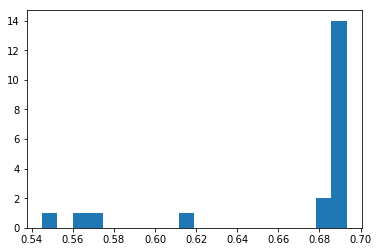

**********************************
Evolution 1
**********************************
Top specimen score: [0.5451343324449327, 0.56050822469923234, 0.57395363516277742, 0.61509947644339669, 0.68198053704367745, 0.68267299731572473, 0.69277914365132653, 0.69299769401550293, 0.6930175622304281, 0.69313703642951119, 0.69313769870334196, 0.69313970539304948, 0.6931401226255629, 0.69314228163825142, 0.69314571221669519, 0.69314895073572791, 0.69315053357018364, 0.69315601719750297, 0.69316099087397254, 0.69317201111051774]
[{'score': 0.5451343324449327, 'cls_design': [{'units': 173, 'dropout': 0.59999999999999998, 'activation': 'leaky_relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faeffd2fa90>}, {'score': 0.56050822469923234, 'cls_design': [{'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7fafb643f2b0>}, {'score': 0.57395363516277742, 'cls_design': [{'units': 89, 'dropout': 0.8

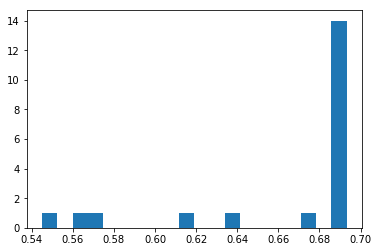

**********************************
Evolution 2
**********************************
Top specimen score: [0.5451343324449327, 0.56050822469923234, 0.57395363516277742, 0.61509947644339669, 0.63940878709157312, 0.67552875147925484, 0.68789622518751359, 0.69236631525887382, 0.69299769401550293, 0.6930175622304281, 0.69313703642951119, 0.69313769870334196, 0.69313830799526643, 0.6931401226255629, 0.69314167896906531, 0.69314228163825142, 0.69314565923478866, 0.69315517610973787, 0.69316528240839637, 0.69316656059688997]
[{'score': 0.5451343324449327, 'cls_design': [{'units': 173, 'dropout': 0.59999999999999998, 'activation': 'relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faeffd2fa90>}, {'score': 0.56050822469923234, 'cls_design': [{'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7fafb643f2b0>}, {'score': 0.57395363516277742, 'cls_design': [{'units': 89, 'dropout': 0.8999999

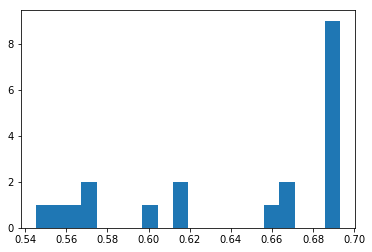

**********************************
Evolution 3
**********************************
Top specimen score: [0.5451343324449327, 0.55568832821316194, 0.56050822469923234, 0.56976013051138985, 0.57395363516277742, 0.60023728344175553, 0.61509947644339669, 0.61646772755516899, 0.66073096460766267, 0.66905701822704744, 0.66929066181182861, 0.69299769401550293, 0.6930175622304281, 0.6931359105639987, 0.69313830799526643, 0.69314228163825142, 0.69314283794826936, 0.69314427508248222, 0.69315517610973787, 0.69316656059688997]
[{'score': 0.5451343324449327, 'cls_design': [{'units': 173, 'dropout': 0.59999999999999998, 'activation': 'relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faeffd2fa90>}, {'score': 0.55568832821316194, 'cls_design': [{'units': 95, 'activation': 'relu', 'dropout': 0.59999999999999998}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faec23c6470>}, {'score': 0

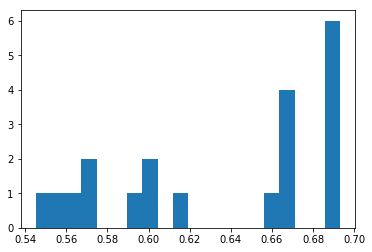

**********************************
Evolution 4
**********************************
Top specimen score: [0.5451343324449327, 0.55568832821316194, 0.56050822469923234, 0.56976013051138985, 0.57293026977115202, 0.59266999695036149, 0.60023728344175553, 0.60173196262783479, 0.61815402242872453, 0.65929860538906526, 0.66566144757800627, 0.66905701822704744, 0.66929066181182861, 0.66929066181182861, 0.68968522548675537, 0.69299769401550293, 0.69313732120725846, 0.69313862588670516, 0.69314427508248222, 0.69317421648237443]
[{'score': 0.5451343324449327, 'cls_design': [{'units': 173, 'dropout': 0.40000000000000002, 'activation': 'relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faeffd2fa90>}, {'score': 0.55568832821316194, 'cls_design': [{'units': 95, 'activation': 'relu', 'dropout': 0.59999999999999998}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faec23c6470>}, {'score':

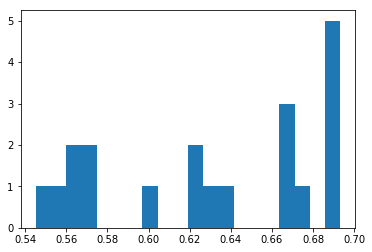

**********************************
Evolution 5
**********************************
Top specimen score: [0.5451343324449327, 0.55568832821316194, 0.56050822469923234, 0.56310320893923438, 0.56976013051138985, 0.57289342747794259, 0.60023728344175553, 0.62076505687501693, 0.62147431903415251, 0.63265244166056311, 0.63434269693162704, 0.66905701822704744, 0.66929066181182861, 0.66929066181182861, 0.67798411183887053, 0.69297154082192314, 0.69299769401550293, 0.69313271178139579, 0.69314427508248222, 0.69314766592449617]
[{'score': 0.5451343324449327, 'cls_design': [{'units': 173, 'dropout': 0.40000000000000002, 'activation': 'relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faeffd2fa90>}, {'score': 0.55568832821316194, 'cls_design': [{'units': 95, 'activation': 'relu', 'dropout': 0.59999999999999998}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faec23c6470>}, {'score':

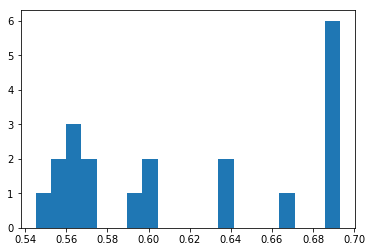

**********************************
Evolution 6
**********************************
Top specimen score: [0.5451343324449327, 0.55444395211007858, 0.55568832821316194, 0.55994314617580843, 0.56050822469923234, 0.56310320893923438, 0.5709701577822367, 0.57289342747794259, 0.59287893772125244, 0.60023728344175553, 0.60023728344175553, 0.63629959026972449, 0.63724484046300256, 0.66905701822704744, 0.6929036180178324, 0.69290601544910002, 0.69297154082192314, 0.69314073191748726, 0.69314427508248222, 0.69318509764141512]
[{'score': 0.5451343324449327, 'cls_design': [{'units': 173, 'dropout': 0.40000000000000002, 'activation': 'relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faeffd2fa90>}, {'score': 0.55444395211007858, 'cls_design': [{'units': 97, 'dropout': 0.54000000000000004, 'activation': 'swish'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7fae862bcb38>}, {'score': 

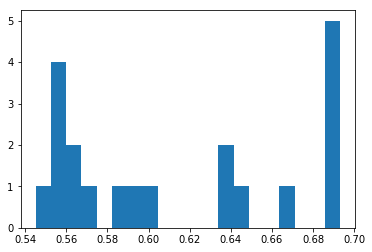

**********************************
Evolution 7
**********************************
Top specimen score: [0.5451343324449327, 0.55444395211007858, 0.55568832821316194, 0.55729166004392838, 0.55994314617580843, 0.56310320893923438, 0.56365598572625053, 0.56762961546579993, 0.58534689744313562, 0.59287893772125244, 0.60023728344175553, 0.63629959026972449, 0.63724484046300256, 0.64157150189081824, 0.66905701822704744, 0.693080829249488, 0.69314581155776978, 0.6931459903717041, 0.69314685795042252, 0.69322549634509611]
[{'score': 0.5451343324449327, 'cls_design': [{'units': 173, 'dropout': 0.40000000000000002, 'activation': 'relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faeffd2fa90>}, {'score': 0.55444395211007858, 'cls_design': [{'units': 97, 'dropout': 0.54000000000000004, 'activation': 'swish'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7fae862bcb38>}, {'score': 0

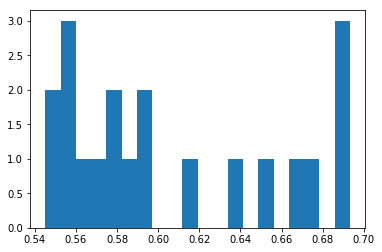

**********************************
Evolution 8
**********************************
Top specimen score: [0.5451343324449327, 0.55088800191879272, 0.55444395211007858, 0.55568832821316194, 0.55729166004392838, 0.56365598572625053, 0.57272161377800834, 0.57553086347050142, 0.5817486180199517, 0.58534689744313562, 0.59287893772125244, 0.59287893772125244, 0.61542709006203544, 0.63629959026972449, 0.65557809008492363, 0.66744082503848601, 0.67627799510955811, 0.69304905335108435, 0.693080829249488, 0.69314638111326432]
[{'score': 0.5451343324449327, 'cls_design': [{'units': 207, 'dropout': 0.40000000000000002, 'activation': 'relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faeffd2fa90>}, {'score': 0.55088800191879272, 'cls_design': [{'units': 118, 'activation': 'leaky_relu', 'dropout': 0.54000000000000004}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7fae5e96a2e8>}, {'sco

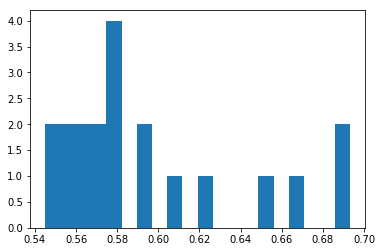

**********************************
Evolution 9
**********************************
Top specimen score: [0.5451343324449327, 0.55088800191879272, 0.55444395211007858, 0.55568832821316194, 0.56034879220856559, 0.56365598572625053, 0.56978535652160645, 0.57132981883154976, 0.57553086347050142, 0.57595150338278878, 0.57614368200302124, 0.57619039879904854, 0.59287893772125244, 0.59500054518381751, 0.60449951887130737, 0.62270303567250573, 0.65557809008492363, 0.6701481872134738, 0.69304905335108435, 0.69304905335108435]
[{'score': 0.5451343324449327, 'cls_design': [{'units': 207, 'dropout': 0.40000000000000002, 'activation': 'relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7faeffd2fa90>}, {'score': 0.55088800191879272, 'cls_design': [{'units': 118, 'activation': 'swish', 'dropout': 0.54000000000000004}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}], 'model': <keras.models.Sequential object at 0x7fae5e96a2e8>}, {'score'

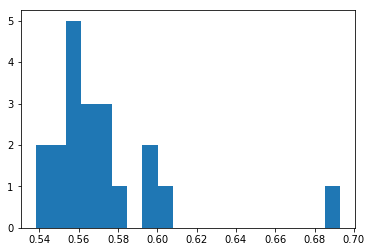

Duration: 11266.96313405037


In [11]:
def batch_gen(batch_sz, data, resize):
    indexes = np.arange(0, len(data), 1)
    start = 0
    while 1:
        x_batch = np.zeros( (batch_sz, resize, resize, 3), dtype=np.float32)
        y_batch = np.zeros( (batch_sz, 1), dtype=np.float32)

        for row in range(batch_sz):
            sample = data[ indexes[row + start] ]
            img = cv2.imread(sample[0], cv2.IMREAD_COLOR)
            img = cv2.resize(img, (resize, resize), interpolation=cv2.INTER_CUBIC)
            #############
            # Add a few lines for data augmentation with affine distorsions
            ######
            img_arr = np.asarray(img)
            x_batch[row] = (img_arr[:,:,:]-128.)/ 128.
            y_batch[row, 0] = sample[1]
        start += batch_sz
        if start + batch_sz > len(indexes):
            np.random.shuffle(indexes)
            start = 0
        yield x_batch, y_batch


def train_specimen(train_data, validation_data, model, batch_sz=128, n_epochs=10, lr=0.000001, patience=5):
    configs = Configs()
    adam = Adam(lr=lr)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    steps_per_epoch = len(train_data) // batch_sz
    validation_steps = len(validation_data) // batch_sz
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)

    list_callbacks = [early_stop]
    resize_img = configs.image_specs[0]
    model.fit_generator(batch_gen(batch_sz, train_data, resize_img), validation_data=batch_gen(batch_sz, validation_data, resize_img),\
                    steps_per_epoch=steps_per_epoch, epochs=n_epochs, validation_steps = validation_steps, verbose=True,
                    callbacks=list_callbacks)
    val_loss, val_acc = model.evaluate_generator(batch_gen(batch_sz, validation_data, resize_img), validation_steps)
    return val_loss, val_acc
    

from time import time    
genalgo = GeneticAlgo()
#initialize population
population = genalgo.build_random_population()
keep_top = 4
keep_simple = 6
n_mutants = 5
n_breeds = 5
n_epochs = 20
patience = 5
num_evolution = 10 

start_time = time()
for i in range(num_evolution):
    #Train each specimen
    print("**********************************")
    print("Evolution {}".format(i))
    print("**********************************")
    if i != 0:
        new_population = list()
        sorted_pop = genalgo.sorted_specimen(population)
        # Keep top specimens
        top_specimens = genalgo.keep_top_specimen( keep_top, sorted_pop )
        print(top_specimens)
        new_population += top_specimens
        print("Top population next gene: {}".format( list(map(lambda x: x["score"], new_population)) ) )
        #keep simple specimens
        simple_specimens = genalgo.keep_simple_specimen(keep_top, keep_simple, sorted_pop)
        new_population += simple_specimens
        
        #Generate breeds from top specimens
        n_breeded = 0
        while n_breeded < n_breeds:
            #randomly pick 2 parents in the previous population
            parents = np.random.choice( population, 2 )
            #only breed parent with more than 1 layer  (dimiss parent with flatten->output)
            if 1 not in list(map(lambda x: len(x["cls_design"]), parents) ):
                specimen = genalgo.breed(parents)
                #check specimen not in population:
                if specimen["cls_design"] not in list(map(lambda x: x["cls_design"], new_population) ):
                    new_population.append( specimen )
                    n_breeded += 1
            
        #Generate mutation from top specimens
        n_mutated = 0
        while n_mutated < n_mutants:
            pick_specimen = np.random.choice( population )
            if len( pick_specimen["cls_design"]) > 1:
                specimen = genalgo.mutate(pick_specimen)
                #check specimen not in population:
                if specimen["cls_design"] not in list(map(lambda x: x["cls_design"], new_population) ):
                    new_population.append( specimen )
                    n_mutated += 1
        
        population = new_population
    
    for idx, specimen in enumerate(population):
        #{"model": cvnet.model, "cls_design": cls.design, "score": None}
        print("----------")
        print(specimen["cls_design"])
        print()
        specimen["model"].summary()
        #train and update score
        if specimen["score"]:
            print("score: {:.2f}".format(specimen["score"]))
        else:
            specimen["score"], val_acc = train_specimen(train_data, validation_data, specimen["model"], batch_sz=128, 
                                           n_epochs=n_epochs, lr=0.0001, patience=patience)
            print("score: {} | Accuracy: {}".format(specimen["score"], val_acc) )
        print()
    # update history:
    ls_scores = list( map(lambda x: x["score"], population) )
    genalgo.history["scores"].append( ls_scores )
    genalgo.history["cls_designs"].append( list( map(lambda x: x["cls_design"], population) ) )
    print("-------------------------")
    print("Average Validation loss for Generation {}: {}".format(i, np.mean( ls_scores )))
    #plot
    x = list( map(lambda x: x["score"], population))
    plt.hist(x, bins=20)
    plt.show()

stop_time = time()
print("Duration: {}".format(stop_time - start_time))

In [13]:
##########################
# Save population: last generation
# I tried dumping list in a pickle file but that does not work: TypeError: can't pickle _thread.lock objects
# also tried hdf5
##########################

#Save each model in a separate hdf file and 
pop = list()
for i in range(len(population)):
    m = population[i]["model"]
    try:
        m.save("specimen"+str(i)+".hdf5")
        pop.append({"model_name": "specimen"+str(i)+".hdf5", "cls_design": population[i]["cls_design"],
                          "score": population[i]["score"]})
    except:
        pop.append({"model_name": None, "cls_design": population[i]["cls_design"],
                          "score": population[i]["score"]})

with open('population.p', 'wb') as handle:
    pickle.dump(pop, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('history.p', 'wb') as handle:
    pickle.dump(genalgo.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [6]:
##################
# My best model
##################

def binary_classifier(img_sz, img_ch):
    model = Sequential()
    #image size = (32, 32, 3)
    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(img_sz, img_sz, img_ch)))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #image size = (16, 16, 32)
    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #image size = (16, 16, 64)
    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #image size = (7, 7, 128)
    model.add(Flatten())
    model.add(Dense(64, activation=swish))
    #model.add(Dense(512, activation=swish_activation))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [7]:
# Parameters
batch_sz = 128
img_sz = 32
n_epochs = 30
patience = 2
lr = 0.0001

my_model = binary_classifier(img_sz, 3)
adam = Adam(lr=lr)
my_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
steps_per_epoch = len(train_data) // batch_sz
validation_steps = len(validation_data) // batch_sz
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
list_callbacks = [early_stop]
my_model.summary()
my_model.fit_generator(batch_gen(batch_sz, train_data, img_sz), validation_data=batch_gen(batch_sz, validation_data, img_sz),\
                    steps_per_epoch=steps_per_epoch, epochs=n_epochs, validation_steps = validation_steps, verbose=True,
                    callbacks=list_callbacks)


val_loss, val_acc = my_model.evaluate_generator(batch_gen(batch_sz, validation_data, img_sz), validation_steps)
print(val_loss, val_acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1261 (Conv2D)         (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1262 (Conv2D)         (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_631 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1263 (Conv2D)         (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_1264 (Conv2D)         (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_632 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1265 (Conv2D)         (None, 8, 8, 128)         73856     
__________

In [14]:
sorted_last_pop = sorted(population, key=itemgetter("score"), reverse=False )

for rank, last_specimen in enumerate(sorted_last_pop):
    print( "Rank: {} ".format(rank) )
    print(last_specimen["cls_design"])

Rank: 0 
[{'units': 97, 'activation': 'relu', 'dropout': 1.0}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}]
Rank: 1 
[{'units': 103, 'dropout': 0.40000000000000002, 'activation': 'swish'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}]
Rank: 2 
[{'units': 118, 'activation': 'relu', 'dropout': 0.54000000000000004}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}]
Rank: 3 
[{'units': 48, 'dropout': 0.40000000000000002, 'activation': 'leaky_relu'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}]
Rank: 4 
[{'units': 87, 'dropout': 0.81000000000000005, 'activation': 'swish'}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}]
Rank: 5 
[{'units': 86, 'activation': 'swish', 'dropout': 1.0}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}]
Rank: 6 
[{'units': 97, 'activation': 'leaky_relu', 'dropout': 0.40000000000000002}, {'units': 1, 'dropout': None, 'activation': 'sigmoid'}]
Rank: 7 
[{'units': 33, 'activation': 'swish', 'dropout': 0.4000000000

In [ ]:
#best model : lowest loss
best_specimen = sorted(population, key=itemgetter("score"), reverse=False )[0]
m = best_specimen["model"]
steps_per_epoch = len(train_data) // batch_sz
validation_steps = len(validation_data) // batch_sz
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
list_callbacks = [early_stop]
m.summary()
m.fit_generator(batch_gen(batch_sz, train_data, img_sz), validation_data=batch_gen(batch_sz, validation_data, img_sz),\
                    steps_per_epoch=steps_per_epoch, epochs=n_epochs, validation_steps = validation_steps, verbose=True,
                    callbacks=list_callbacks)


val_loss, val_acc = m.evaluate_generator(batch_gen(batch_sz, validation_data, img_sz), validation_steps)
print(val_loss, val_acc)

In [ ]:
a = np.arange(0, 1, 1)
np.random.choice(a)